In [1]:
import functools
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [2]:
raw_df = pd.read_csv("UserAnimeList.csv")

In [3]:
filtered_df = raw_df[["username", "anime_id", "my_score"]].loc[
    lambda x: x["my_score"] != 0
]

In [4]:
def read_xml(file, username):
    import xml.etree.ElementTree as ET

    xml_data = open(file, "r").read()  # Read file
    root = ET.XML(xml_data)  # Parse XML

    data = []
    cols = []
    for i, child in enumerate(root):
        data.append([subchild.text for subchild in child])
        cols.append(child.tag)
    new_list = pd.DataFrame(data).T
    new_list.columns = cols

    df = new_list.loc[[0, 9]].T.dropna().rename({0: "anime_id", 9: "my_score"}, axis=1)
    df["username"] = username
    df["anime_id"] = df["anime_id"].astype(int)
    df["my_score"] = df["my_score"].astype(int)
    df["username"] = df["username"].astype(str)
    df = df.loc[lambda x: x["my_score"] != 0]
    df = df.reset_index(drop=True)
    return df


def add_user(full_df, xml_file, username):
    user_df = read_xml(xml_file, username)
    without_user = full_df.loc[lambda x: x["username"] != username]
    return pd.concat([without_user, user_df], ignore_index=True)

In [5]:
filtered_df = add_user(filtered_df, "user_profiles/Fro116.xml", "Fro116")

In [6]:
average_rating = filtered_df["my_score"].mean()
user_bias = (
    pd.DataFrame(filtered_df.groupby("username")["my_score"].mean()).rename(
        {"my_score": "user_bias"}, axis=1
    )
    - average_rating
)
anime_bias = (
    pd.DataFrame(filtered_df.groupby("anime_id")["my_score"].mean()).rename(
        {"my_score": "anime_bias"}, axis=1
    )
    - average_rating
)

In [7]:
filtered_df = filtered_df.merge(anime_bias, on=["anime_id"]).merge(
    user_bias, on=["username"]
)
filtered_df["normalized_score"] = (
    filtered_df["my_score"]
    - filtered_df["anime_bias"]
    - filtered_df["user_bias"]
    - average_rating
)
filtered_df["orig_normalized_score"] = filtered_df["normalized_score"]
filtered_df = filtered_df.set_index("username")
filtered_df = filtered_df.dropna()

In [8]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df["delta"] = neighborhood.groupby("anime_id").apply(
        lambda x: np.dot(x["normalized_score"], x["corr"]) / x["corr"].abs().sum()
    )
    pred_df["blp"] = anime_bias + user_bias.loc[recommendee].squeeze() + average_rating
    pred_df = pred_df.dropna()
    return pred_df

In [9]:
def get_correlation(df, recommendee):
    user_subset = df.loc[[recommendee]].merge(df.reset_index(), on="anime_id")
    adj_cos_corr_numerator = user_subset.groupby("username").apply(
        lambda x: np.dot(x["normalized_score_x"], x["normalized_score_y"])
    )
    adj_cos_corr_denom = df.groupby("username").apply(
        lambda x: np.sqrt(np.dot(x["normalized_score"], x["normalized_score"]))
    )
    adj_cos_corr_denom *= adj_cos_corr_denom.loc[recommendee]
    adj_cos_corrs = pd.DataFrame(
        (adj_cos_corr_numerator / adj_cos_corr_denom), columns=["corr"]
    )
    adj_cos_corrs = adj_cos_corrs.dropna()
    return adj_cos_corrs

In [10]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[
        pred_df.index.intersection(df.loc[recommendee].anime_id)
    ]
    recommendee_df = recommendee_df.merge(
        df.loc[recommendee].set_index("anime_id")["my_score"], on="anime_id"
    )
    errors = recommendee_df["my_score"] - recommendee_df["score"]
    return np.dot(errors, errors)

In [11]:
filtered_df.head()

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
karthiga,21,9,0.960564,-0.059898,0.605473,0.605473
karthiga,59,7,0.040203,-0.059898,-0.474166,-0.474166
karthiga,74,7,0.316283,-0.059898,-0.750245,-0.750245
karthiga,120,7,0.309858,-0.059898,-0.743821,-0.743821
karthiga,178,7,-0.227338,-0.059898,-0.206624,-0.206624


In [12]:
def compute_accuracy_metrics(
    is_df, oos_df, recommendee, neighborhood_sizes, normalize_variance
):

    # Should we normalize by variance?
    # Note that normalize_variance=True modifies the data
    if normalize_variance:
        user_stds = (
            is_df.groupby("username")[["normalized_score"]]
            .std()
            .rename({"normalized_score": "user_std"}, axis=1)
        )
        is_df = is_df.merge(user_stds, on="username")
        is_df["normalized_score"] /= is_df["user_std"]
        is_df = is_df.drop("user_std", axis=1)

    # compute correlations
    corrs = get_correlation(is_df, recommendee)
    corrs["similarity"] = corrs["corr"].abs()
    corrs = corrs.sort_values(by="similarity").dropna()
    corrs = corrs.drop(recommendee)  # makes insample score more meaningful

    metrics = pd.DataFrame()
    for neighborhood_size in neighborhood_sizes:
        # extract model features
        neighborhood = (
            is_df.merge(pd.DataFrame(corrs[-neighborhood_size:]), on="username")
        ).dropna()
        pred_df = prepare_prediction(recommendee, neighborhood)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on=["anime_id"])
        recomendee_seen_shows["target"] = (
            recomendee_seen_shows["my_score"] - recomendee_seen_shows["blp"]
        )
        model = lm("target ~ delta + 0", recomendee_seen_shows)

        # inference
        pred_df["score"] = model.predict(pred_df) + pred_df["blp"]
        is_pred_df = pred_df.loc[
            lambda x: x.index.isin(is_df.loc[recommendee].anime_id)
        ]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[recommendee])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, recommendee)
        oos_se = get_squared_error(oos_df, oos_pred_df, recommendee)
        missing_is_se = np.dot(
            missing_is["orig_normalized_score"], missing_is["orig_normalized_score"]
        )
        missing_oos_se = np.dot(
            missing_oos["orig_normalized_score"], missing_oos["orig_normalized_score"]
        )
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "normalize_variance": normalize_variance,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [13]:
%%time
from tqdm import tqdm

recommendee = "Fro116"
K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(len(filtered_df)) / np.log(base)) + 1)
] + [len(filtered_df)]
splits = np.array_split(filtered_df.loc[recommendee].sample(frac=1), K)

for split in tqdm(splits):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == recommendee)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    # we take copies because setting normalize_variance=True modifies the data
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), "Fro116", neighborhood_sizes, True
        )
    )
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), "Fro116", neighborhood_sizes, False
        )
    )

100%|██████████| 10/10 [9:16:34<00:00, 3339.49s/it] 

CPU times: user 5h 54min 51s, sys: 1h 37min 17s, total: 7h 32min 9s
Wall time: 9h 16min 36s


In [14]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [15]:
allerrors

,is_coverage,is_rmse,neighborhood_size,normalize_variance,oos_coverage,oos_rmse
0,0.008902,1.567559,1.0,1.0,0.000000,1.731232
1,0.008902,1.567559,1.0,1.0,0.000000,1.731232
2,0.032641,1.539400,2.0,1.0,0.026316,1.711959
3,0.032641,1.539400,2.0,1.0,0.026316,1.711959
4,0.142433,1.512222,4.0,1.0,0.157895,1.690107
...,...,...,...,...,...,...
1035,0.923077,0.806093,11863283.0,0.0,0.891892,1.111266
1036,0.923077,0.806093,16777216.0,0.0,0.891892,1.111266
1037,0.923077,0.806093,23726566.0,0.0,0.891892,1.111266
1038,0.923077,0.806093,33554432.0,0.0,0.891892,1.111266


In [16]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "normalize_variance"])

In [17]:
wide_data.loc[lambda x: x.normalize_variance == True, "variable"] = (
    "normalized_" + wide_data.loc[lambda x: x.normalize_variance == True, "variable"]
)

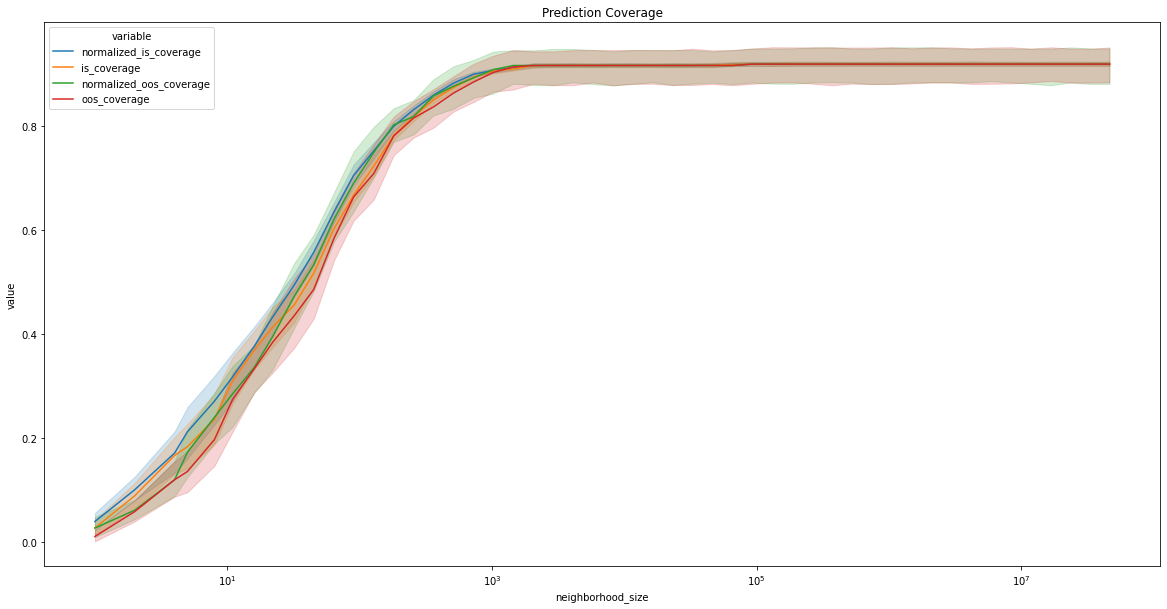

In [27]:
plt.figure(figsize=(20,10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

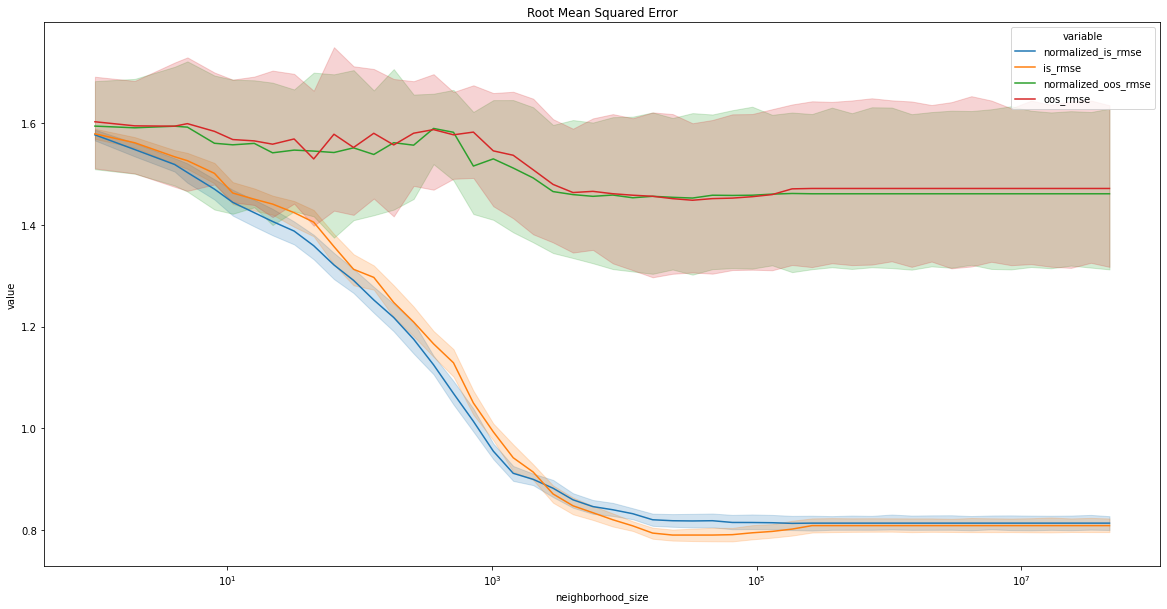

In [26]:
plt.figure(figsize=(20,10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [93]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(10)

is_coverage   is_rmse  oos_coverage  oos_rmse
normalize_variance neighborhood_size                                               
0.0                32768.0               0.917329  0.789738      0.916999  1.448625
                   23170.0               0.917329  0.789720      0.916999  1.451758
                   46340.0               0.917625  0.789739      0.916999  1.451846
                   65536.0               0.919106  0.790504      0.916999  1.452821
1.0                32768.0               0.917329  0.817484      0.916999  1.452951
                   11585.0               0.917329  0.831753      0.916999  1.453499
                   23170.0               0.917329  0.817908      0.916999  1.454408
0.0                92681.0               0.919699  0.794183      0.919630  1.455608
1.0                5792.0                0.917329  0.845754      0.916999  1.456342
                   16384.0               0.917329  0.819846      0.916999  1.456377

In [ ]:
# My takeaway from this is that it doesn't matter if we normalize variance or not
# For simplicity, let's forgo normalization

In [100]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().xs(0, level='normalize_variance').sort_values(
    by="oos_rmse"
).head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
32768.0,0.917329,0.789738,0.916999,1.448625
23170.0,0.917329,0.789720,0.916999,1.451758
46340.0,0.917625,0.789739,0.916999,1.451846
65536.0,0.919106,0.790504,0.916999,1.452821
92681.0,0.919699,0.794183,0.919630,1.455608
16384.0,0.917329,0.793605,0.916999,1.456436
11585.0,0.917329,0.807816,0.916999,1.458525
131072.0,0.919699,0.796887,0.919630,1.459760
8192.0,0.917329,0.819847,0.916999,1.461425


In [113]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().xs(0, level='normalize_variance').sort_values(
    by="is_rmse"
).head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
23170.0,0.917329,0.789720,0.916999,1.451758
32768.0,0.917329,0.789738,0.916999,1.448625
46340.0,0.917625,0.789739,0.916999,1.451846
65536.0,0.919106,0.790504,0.916999,1.452821
16384.0,0.917329,0.793605,0.916999,1.456436
92681.0,0.919699,0.794183,0.919630,1.455608
131072.0,0.919699,0.796887,0.919630,1.459760
185363.0,0.919995,0.801478,0.919630,1.471047
11585.0,0.917329,0.807816,0.916999,1.458525


In [106]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().xs(0, level='normalize_variance')

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
1.0,0.027237,1.579364,0.010811,1.603097
2.0,0.089196,1.561761,0.058748,1.595024
4.0,0.166857,1.534174,0.119986,1.594383
5.0,0.183468,1.526467,0.135775,1.599367
8.0,0.236499,1.501560,0.197155,1.584208
11.0,0.310831,1.462850,0.274964,1.568076
16.0,0.369215,1.450683,0.333428,1.565427
22.0,0.413639,1.441073,0.384282,1.558946
32.0,0.455972,1.424227,0.435349,1.569221


In [114]:
allerrors.groupby(["normalize_variance", "neighborhood_size"]).apply(lambda x: np.sqrt(np.sum(x**2) / K)).xs(0, level='normalize_variance')

,is_coverage,is_rmse,neighborhood_size,normalize_variance,oos_coverage,oos_rmse
neighborhood_size,,,,,,
1.0,0.063574,2.233810,1.414214e+00,0.0,0.038222,2.286399
2.0,0.150708,2.208921,2.828427e+00,0.0,0.105533,2.275140
4.0,0.176274,1.534334,4.000000e+00,0.0,0.132194,1.606848
5.0,0.196004,1.526670,5.000000e+00,0.0,0.149871,1.612125
8.0,0.249614,1.501931,8.000000e+00,0.0,0.211802,1.595266
11.0,0.319572,1.463295,1.100000e+01,0.0,0.289071,1.580285
16.0,0.374469,1.451107,1.600000e+01,0.0,0.341931,1.579376
22.0,0.418875,1.441355,2.200000e+01,0.0,0.397175,1.576844
32.0,0.459055,1.424796,3.200000e+01,0.0,0.449676,1.582539
